## Check version of tensorflow

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


## Import Libraries

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from gensim.models import KeyedVectors

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/My Drive/Tweets/

/content/drive/My Drive/Tweets


## Load Data

In [9]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'tweet']
df = pd.read_csv('Tweets-1.6M.csv', encoding=('latin-1'), names=cols)
df

,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [10]:
np.random.seed(0)     # To solve randomness problem after each run

## Take a 500,000 samples randomly

In [11]:
index = np.random.randint(low=0,high=1599999,size= 500000)
data = df.loc[index, ['tweet', 'sentiment']].reset_index(drop=True)
data['sentiment'] = data['sentiment'].replace({4:1})          # make positive labels 1 instead of 4
data

,tweet,sentiment
0,@rlangdon .... but I want it to be real. You w...,0
1,@ketadiablo - Just finished DUST AND MOONLIGHT...,1
2,@marchingstars i feel bad for the zines i stil...,0
3,@kahilee Sounds like it was a blast! Have a sa...,1
4,"@majornelson LOVING the zune, hating the lack ...",0
...,...,...
499995,nothing like a girls night to make my bad day ...,1
499996,"@amyeandrews thanks, Amy. It should finally ar...",1
499997,Only 291 tweets away from my 1000th LOL,1
499998,@hannahhlouise i made it out aliveeeee,1


## Count number of positive and negative labels

In [12]:
data['sentiment'].value_counts()

1    250148
0    249852
Name: sentiment, dtype: int64

## Convert data frame into list

In [13]:
text = data['tweet'].values.tolist()
text

['@rlangdon .... but I want it to be real. You would level up your geek cred! ',
 '@ketadiablo - Just finished DUST AND MOONLIGHT this week. So glad about you have a sequel. ',
 "@marchingstars i feel bad for the zines i still need to send you! eep! same goes to @maeundead. i'm sorry ",
 "@kahilee Sounds like it was a blast! Have a safe flight and hope you get some rest. I can't imagine catching a flight the next morning! ",
 '@majornelson LOVING the zune, hating the lack of Canada love ',
 "I'm freaking hell tired,but I don't feel like sleeping. I dont know why ",
 'Funniest twitter profile pic in my opinion  http://tinyurl.com/nsdmbr',
 "Off to bed. My Shakespeare final is tomorrow and I so don't feel ready for it. ",
 'ugh, how could i forgot my glove full of water with an eyeball in it!? ',
 'rest in peace grandma. gone but never forgotten. gonna put her 6 feet under the ground tomorrow      love you&amp;miss you!  &lt;/3',
 'has just woke up , got a mega hangover ',
 'Have no lapt

## Define dictionary containing all emojis with their meanings

In [14]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Clean data

In [15]:
wordLemm = WordNetLemmatizer()
stop_words = stopwords.words('english')
def clean_text(txt):
    # Defining regex patterns.
    pat1 = '@[^ ]+'
    pat2 = 'http[^ ]+'
    pat3 = 'www.[^ ]+'
    pat4 = '#[^ ]+'
    pat5 = '[0-9]'
    combined_pat = '|'.join((pat1, pat2, pat3, pat4, pat5))
    txt = txt.lower()
    txt = re.sub(combined_pat, '', txt)
    txt = re.sub("n't", "not", txt)
    txt = re.sub("i'm|im", "i am", txt)
    txt = re.sub("i'll", "i will", txt)
    txt = re.sub("you're", "you are", txt)
    txt = re.sub("they're", "they are", txt)
    txt = re.sub(' u ', " you ", txt)
    table = str.maketrans('', '', string.punctuation)
    txt = " ".join(w.translate(table) for w in txt.split())
    # Replace 3 or more consecutive letters by 2 letter.
    txt = re.sub(r"(.)\1\1+", r"\1\1", txt)
    tokenized_words = word_tokenize(txt)
    txt ="".join(wordLemm.lemmatize(i, 'v')+' ' for i in tokenized_words if i not in stop_words)
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

In [16]:
text = [clean_text(i) for i in text]
text

['want real would level geek cred ',
 'finish dust moonlight week glad sequel ',
 'feel bad zines still need send eep go sorry ',
 'sound like blast safe flight hope get rest canot amagine catch flight next morning ',
 'love zune hat lack canada love ',
 'freak hell tiredbut donot feel like sleep dont know ',
 'funniest twitter profile pic opinion ',
 'bed shakespeare final tomorrow donot feel ready ',
 'ugh could forget glove full water eyeball ',
 'rest peace grandma go never forget gon na put feet grind tomorrow love youampmiss lt ',
 'wake get mega hangover ',
 'laptop moe twitter ',
 'history exam hour since six feel physically sick eurgh canot wait ',
 'unpack new apartment ',
 'im actually enjoyinq crazy nice day medellin ',
 'wish could go tortola ',
 'haha aww go miss moments love blink hallway todayblue tshirt cult ',
 'listen ftsks music awesome underdog alma mater ',
 'good know ok frustrate scary ',
 'graduation sombody house burn dwn ',
 'omg really happy moment ',
 'open

In [17]:
clean_df = pd.DataFrame(text, columns=['tweets'])
clean_df ['sentiment'] = data['sentiment']
clean_df

,tweets,sentiment
0,want real would level geek cred,0
1,finish dust moonlight week glad sequel,1
2,feel bad zines still need send eep go sorry,0
3,sound like blast safe flight hope get rest can...,1
4,love zune hat lack canada love,0
...,...,...
499995,nothing like girls night make bad day turn awe...,1
499996,thank amy finally arrive today track last one ...,1
499997,tweet away th lol,1
499998,make alivee,1


## Split features and label

In [18]:
X = clean_df['tweets']
y = clean_df['sentiment']

## Split data into train and test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## show most frequent words in positive and negative labels

In [20]:
def most_freq_word(df):
    pos_df = df[df['sentiment']==1]
    neg_df = df[df['sentiment']==0]
    pos_str = pos_df['tweets'].str.cat(sep=' ')
    neg_str = neg_df['tweets'].str.cat(sep=' ')
    pos_words = nltk.tokenize.word_tokenize(pos_str)
    neg_words = nltk.tokenize.word_tokenize(neg_str)
    pos_word = nltk.FreqDist(pos_words)
    neg_word = nltk.FreqDist(neg_words)
    pos_rslt = pd.DataFrame(pos_word.most_common(30),
                    columns=['pos_Word', 'Frequency']).set_index('pos_Word')
    matplotlib.style.use('ggplot')
    pos_rslt.plot.barh(rot=0)
    
    neg_rslt = pd.DataFrame(neg_word.most_common(30),
                    columns=['neg_Word', 'Frequency']).set_index('neg_Word')

    matplotlib.style.use('ggplot')

    neg_rslt.plot.barh(rot=0)

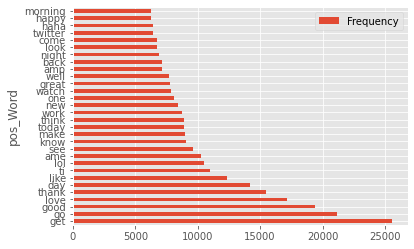

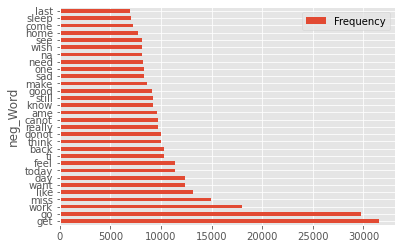

In [21]:
most_freq_word(clean_df)

In [22]:
X_train

265410    cook unusual version thai green chicken curry ...
435559    heh always pi amping hi twitter shameless real...
254095               ah mate enjoy well think stuffy halls 
18311                            ready bed tons work later 
344016                     get finish nailsnow hair ti ame 
                                ...                        
439107                tenk tweet nice ones must add hahaha 
117952                                             hehe ok 
435829                        bah thats pretty rotten form 
305711                         oh rip wayman canot believe 
461484    ahr ahh phone break yep break haha bull shit y...
Name: tweets, Length: 350000, dtype: object

## Tokenize training data

In [23]:
tk = Tokenizer()
tk.fit_on_texts(X_train)

### calculate total number of words

In [24]:
total_words = len(tk.word_index) + 1
total_words

121549

## Vectorize training and testing data

In [25]:
X_train = tk.texts_to_sequences(X_train)
X_test = tk.texts_to_sequences(X_test)

## Zero padding training and testing data

In [26]:
max_len = max([len(i) for i in X_train])
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

In [27]:
X_test.shape       # Check shape of test data

(150000, 39)

## Load Google's pre-trained Word2Vec

In [28]:
word2vec = KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Create embedding matrix

In [29]:
embedding_dim = word2vec['king'].shape[0]
embedding_matrix = np.zeros((total_words, embedding_dim))

for word, i in tk.word_index.items():       
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec[word]      

embedding_matrix.shape   

(121549, 300)

## Implement LSTM model

In [30]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=embedding_dim,
                    input_length=max_len, weights=[embedding_matrix]))
model.add(LSTM(embedding_dim, return_sequences=False, dropout = 0.5))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 300)           36464700  
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 37,205,229
Trainable params: 37,205,229
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [31]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=2)
model.save("sentiment_analysis_model.h5")

Epoch 1/5
5469/5469 - 3029s - loss: 0.4906 - accuracy: 0.7648 - val_loss: 0.4545 - val_accuracy: 0.7864
Epoch 2/5
5469/5469 - 3074s - loss: 0.4029 - accuracy: 0.8185 - val_loss: 0.4447 - val_accuracy: 0.7920
Epoch 3/5
5469/5469 - 3125s - loss: 0.3294 - accuracy: 0.8556 - val_loss: 0.4891 - val_accuracy: 0.7911
Epoch 4/5
5469/5469 - 3085s - loss: 0.2898 - accuracy: 0.8729 - val_loss: 0.4825 - val_accuracy: 0.7944
Epoch 5/5
5469/5469 - 3007s - loss: 0.2636 - accuracy: 0.8853 - val_loss: 0.5229 - val_accuracy: 0.7912


## Evaluate the model 

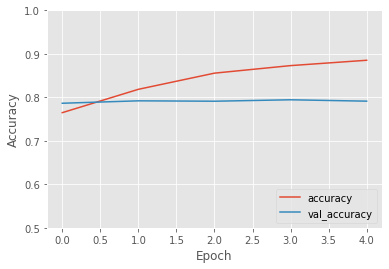

In [34]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### saving training data to get max length of data for padding in prediction

In [47]:
np.savetxt('X_train', X_train, fmt='%d') 

## create function to take sentence from user and predict whether it's positive or negative

In [42]:
def prediction(seed_text, model, max_len):
    seed_text = clean_text(seed_text)
    token_list = tk.texts_to_sequences([seed_text])
    token_list = pad_sequences(token_list, maxlen=max_len, padding='post')
    predicted = model.predict(token_list)[0]
    if predicted > 0.5:
        return 'pos'
    else:
        return 'neg'

## Load the model

In [ ]:
model = load_model('sentiment_analysis_model.h5')  

## Load training data and calculate max length

In [48]:
x_train = np.loadtxt('X_train', dtype=int)
max_length = max([len(i) for i in x_train])

## Test the model

In [49]:
pred = prediction("I dont't like that", model, max_length)
pred

'neg'